In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
data = torch.tensor(pd.read_csv("data.txt", header=None).values)
data.shape

torch.Size([10000, 1])

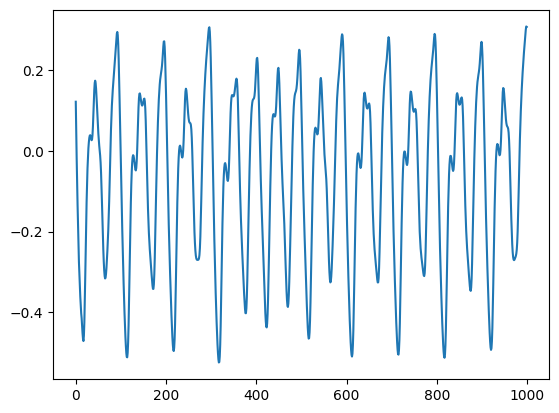

In [9]:
plt.plot(data[:1000])

In [10]:
CONTEXT_LENGTH = 8
EPOCHS = 30
LEARNING_RATE = 3e-4
BATCH_SIZE = 16
HIDDEN_SIZE = 32

In [11]:
arr = [data[i:i+CONTEXT_LENGTH] for i in range(len(data) - CONTEXT_LENGTH)]
x = torch.hstack(arr).transpose(0, 1)
y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)
x.shape, y.shape

C:\Users\adika\AppData\Local\Temp\ipykernel_22284\1857358162.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(data[CONTEXT_LENGTH:len(data)], requires_grad=True)


(torch.Size([9992, 8]), torch.Size([9992, 1]))

In [12]:
x[-1], y[-1]

(tensor([-0.3097, -0.2974, -0.2785, -0.2549, -0.2285, -0.2002, -0.1701, -0.1373],
        dtype=torch.float64),
 tensor([-0.1003], dtype=torch.float64, grad_fn=<SelectBackward0>))

In [13]:
x[0], y[0]

(tensor([ 0.1221,  0.0472, -0.0183, -0.0819, -0.1342, -0.1854, -0.2293, -0.2755],
        dtype=torch.float64),
 tensor([-0.3058], dtype=torch.float64, grad_fn=<SelectBackward0>))

In [14]:
size = int(0.8 * x.shape[0])
X_train = x[:size]
y_train = y[:size]

X_test = x[size:]
y_test = y[size:]

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([7993, 8]),
 torch.Size([7993, 1]),
 torch.Size([1999, 8]),
 torch.Size([1999, 1]))

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = DataLoader(TimeSeriesDataset(X_train, y_train), BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(TimeSeriesDataset(X_test, y_test), BATCH_SIZE, shuffle=True)

In [17]:
train_dataset = DataLoader(TimeSeriesDataset(X_train, y_train), BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(TimeSeriesDataset(X_test, y_test), BATCH_SIZE, shuffle=True)

In [18]:
print("Train Data Shape: (N, BATCH_SIZE, CONTEXT_SIZE)")

Train Data Shape: (N, BATCH_SIZE, CONTEXT_SIZE)


In [19]:
class RNNCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super().__init__()
        self.Wxh = nn.Linear(in_dim, hidden_dim)
        self.Whh = nn.Linear(hidden_dim, hidden_dim)
        self.Who = nn.Linear(hidden_dim, out_dim)

    def forward(self, xt, ht):
        xh = self.Wxh(xt)
        hidden_state = self.Whh(ht)
        hidden_state = F.tanh(hidden_state + xh)
        output = self.Who(hidden_state)
        return (hidden_state, output)


class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cell = RNNCell(in_dim, hidden_dim)
    
    def forward(self, x):
        h_t_minus_1 = torch.zeros(HIDDEN_SIZE)
        h_t = torch.zeros(HIDDEN_SIZE)
        res = []
        for t in range(x.shape[0]):
            h_t, output = self.cell(x[t], h_t_minus_1)
            res.append(output)
            h_t_minus_1 = h_t

        res = torch.stack(res)
        return res

In [20]:
def train_epoch(model, optim):
    lossi = []
    for x, y in train_dataset:
        output = model(x.float())
        loss = F.mse_loss(output, y.float())

        optim.zero_grad()
        loss.backward()
        optim.step()

        lossi.append(loss.item())
    
    return torch.tensor(lossi).mean().item()


@torch.no_grad()
def val_epoch(model):
    lossi = []
    for x, y in test_dataset:
        output = model(x.float())
        loss = F.mse_loss(output, y.float())
        lossi.append(loss.item())
    
    return torch.tensor(lossi).mean().item()

In [21]:
model = RNN(CONTEXT_LENGTH, HIDDEN_SIZE)
optim = torch.optim.AdamW(model.parameters(), LEARNING_RATE)

for name, i in model.named_parameters():
    print(name, ": ", i.shape, i.grad)

cell.Wxh.weight :  torch.Size([32, 8]) None
cell.Wxh.bias :  torch.Size([32]) None
cell.Whh.weight :  torch.Size([32, 32]) None
cell.Whh.bias :  torch.Size([32]) None
cell.Who.weight :  torch.Size([1, 32]) None
cell.Who.bias :  torch.Size([1]) None


In [23]:
train_lossi = []
test_lossi = []
for epoch in range(EPOCHS):
  train_loss = train_epoch(model, optim)
  test_loss = val_epoch(model)

  train_lossi.append(train_loss)
  test_lossi.append(test_loss)

  print(f"EPOCH: {epoch} |  TRAIN-LOSS: {train_loss} |  VAL-LOSS: {test_loss}")

EPOCH: 0 |  TRAIN-LOSS: 0.011342949233949184 |  VAL-LOSS: 0.0017362373182550073
EPOCH: 1 |  TRAIN-LOSS: 0.001284153899177909 |  VAL-LOSS: 0.0010840140748769045
EPOCH: 2 |  TRAIN-LOSS: 0.0010105767287313938 |  VAL-LOSS: 0.0008712940034456551
EPOCH: 3 |  TRAIN-LOSS: 0.0008021477260626853 |  VAL-LOSS: 0.0006728423177264631
EPOCH: 4 |  TRAIN-LOSS: 0.0006095091812312603 |  VAL-LOSS: 0.0004985930863767862
EPOCH: 5 |  TRAIN-LOSS: 0.00043741747504100204 |  VAL-LOSS: 0.0003430915530771017
EPOCH: 6 |  TRAIN-LOSS: 0.00031199658405967057 |  VAL-LOSS: 0.0002661055186763406
EPOCH: 7 |  TRAIN-LOSS: 0.0002313030418008566 |  VAL-LOSS: 0.00019726366735994816
EPOCH: 8 |  TRAIN-LOSS: 0.00018165538494940847 |  VAL-LOSS: 0.0001572295732330531
EPOCH: 9 |  TRAIN-LOSS: 0.0001547265419503674 |  VAL-LOSS: 0.000133019158965908
EPOCH: 10 |  TRAIN-LOSS: 0.0001397815067321062 |  VAL-LOSS: 0.00012210814747959375
EPOCH: 11 |  TRAIN-LOSS: 0.000129114487208426 |  VAL-LOSS: 0.00011718593304976821
EPOCH: 12 |  TRAIN-LOSS:

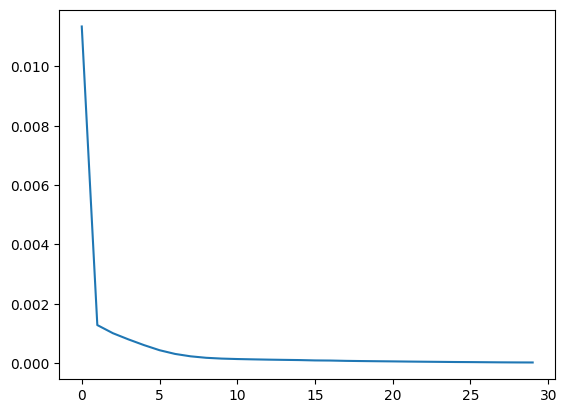

In [24]:
plt.plot(train_lossi)

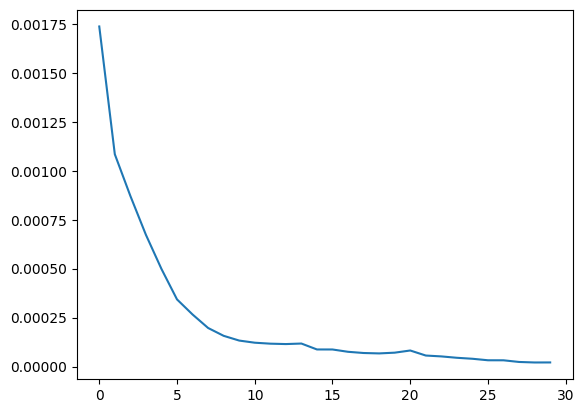

In [25]:
plt.plot(test_lossi)

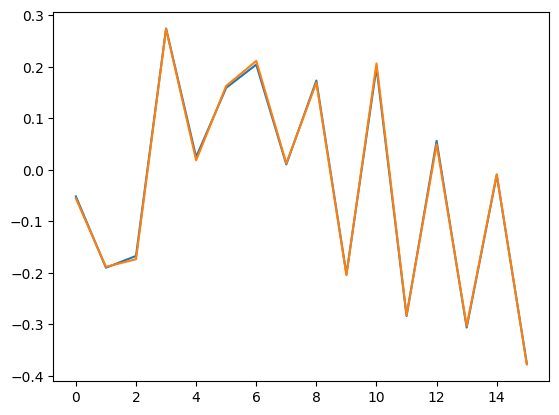

In [26]:
for i in test_dataset:
    x, y = i
    output = model(x.float())

    plt.plot(y.detach().numpy())
    plt.plot(output.detach().numpy())
    break